# Coursera Capstone
# The Battle of the Neighborhoods
This document will be used for the Coursera Capstone project, part of the IBM Data Science Professional Certificate.

In [56]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from shapely.geometry import Point, Polygon

import shapely.speedups #For point in polygon calculations
shapely.speedups.enable()

import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import K Nearest Neightbors
from sklearn.neighbors import KNeighborsClassifier

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Create a dataframe of neighborhoods in Minneapolis
As far as I could tell, the data for Minneapolis neighborhoods did not come attached with latitude and longitude values. The following section creates a dataframe with neighborhood names and attached lat/long values.

In [57]:
# Data retrieved from
# https://opendata.minneapolismn.gov/datasets/minneapolis-neighborhoods
# Data downloaded and placed in local directory.

with open('Minneapolis_Neighborhoods.geojson.json') as jsondata:
    mpls_data = json.load(jsondata)
    
with open('Communities.geojson') as jsondata:
    mpls_comm_data = json.load(jsondata)
    
with open('stp_neighborhoods.geojson') as jsondata:
    stp_nbhd_data = json.load(jsondata)

Define `mpls_nbhds` to be the features of the geojson file imported above.

In [58]:
# We will refer back to the larger mpls_data dataframe later.
mpls_nbhds = mpls_data['features']
stp_nbhds = stp_nbhd_data['features']

In [19]:
# Look at the first entry. Note the neighborhood name has key 'BDNAME'
# mpls_nbhds
stp_nbhds #We want 'name2'

[{'type': 'Feature',
  'properties': {'district': '12',
   'name1': 'St. Anthony Park Community Council',
   'name2': 'St Anthony Park'},
  'geometry': {'type': 'MultiPolygon',
   'coordinates': [[[[-93.20777042679448, 44.959716760336484],
      [-93.20777481826674, 44.96279738280075],
      [-93.20774279554496, 44.96640608571766],
      [-93.20771076994284, 44.97001482879403],
      [-93.20769012500848, 44.97361197441011],
      [-93.20766971822941, 44.9772091605449],
      [-93.20764151787235, 44.980827202494226],
      [-93.20761331270101, 44.98444524134255],
      [-93.20758486555337, 44.98806246419193],
      [-93.20248383429042, 44.98806568304071],
      [-93.19738256156657, 44.98806867267917],
      [-93.19228273064918, 44.988073150909266],
      [-93.18718265819201, 44.988077357724514],
      [-93.18722300547098, 44.98446333011602],
      [-93.18726262074601, 44.98084981192919],
      [-93.1873025644533, 44.97723629211431],
      [-93.18223473329738, 44.97724701621978],
      [

Empty DataFrame
Columns: [Neighborhood, Latitude, Longitude]
Index: []

Neighborhood Latitude Longitude
0      Phillips West      NaN       NaN
1      Downtown West      NaN       NaN
2      Downtown East      NaN       NaN
3    Ventura Village      NaN       NaN
4  Sumner - Glenwood      NaN       NaN

#### Populate the latitude and longitude using Geopy

In [68]:
# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
df_nbhds_mpls = pd.DataFrame(columns=column_names)

# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in mpls_nbhds:
    nbhd_name = data['properties']['BDNAME']
    df_nbhds_mpls = df_nbhds_mpls.append({'Neighborhood':nbhd_name}, ignore_index=True)

# Populate lat/lon values for neighborhoods. Gather values not found by Geopy.
missing_latlons = []
for nbhd in df_nbhds_mpls['Neighborhood']:
    address = nbhd + ', Minneapolis, MN'
    geolocator = Nominatim(user_agent="mpls_explorer")
    location = geolocator.geocode(address)
    if location is None:
        print(address+' is not found on geopy.')
        missing_latlons = missing_latlons +[nbhd]
    else:
        df_nbhds_mpls.loc[df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood'] == nbhd].to_list(),'Latitude']= location.latitude
        df_nbhds_mpls.loc[df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood'] == nbhd].to_list(),'Longitude']= location.longitude
    
print(missing_latlons)
df_nbhds_mpls.head()

Downtown West, Minneapolis, MN is not found on geopy.
Ventura Village, Minneapolis, MN is not found on geopy.
South Uptown, Minneapolis, MN is not found on geopy.
Mid - City Industrial, Minneapolis, MN is not found on geopy.
Nicollet Island - East Bank, Minneapolis, MN is not found on geopy.
['Downtown West', 'Ventura Village', 'South Uptown', 'Mid - City Industrial', 'Nicollet Island - East Bank']


Neighborhood Latitude Longitude
0      Phillips West  44.9539  -93.2663
1      Downtown West      NaN       NaN
2      Downtown East   44.975  -93.2599
3    Ventura Village      NaN       NaN
4  Sumner - Glenwood  44.9837  -93.2914

There are 5 neighborhoods that Geopy could not identify. We can manually input these by pulling the location data from a google search.

In [69]:
# Manually look up missing lat/lon values for these neighborhoods.
Downtown_West =[44.9742, -93.2733]
Ventura_Village = [44.9618, -93.2582]
# This neighborhood is now found on geopy...
#Humboldt_Industrial_Area = [45.0421, -93.3077]
South_Uptown = [44.9411, -93.2911]
Mid_City_Industrial = [44.9989, -93.2178]
Nicollet_Island = [44.9879, -93.2629]

missing_mpls = [Downtown_West, Ventura_Village, South_Uptown, Mid_City_Industrial, Nicollet_Island]

# Populate dictionary of neighborhoods and missing lat/long values
missing_dict={}
for j in range(0,len(missing_mpls)):
    entry ={missing_latlons[j]:missing_mpls[j]}
    missing_dict.update(entry)


# Fill in missing lat/long values into our dataframe
for j in range(0,len(missing_mpls)):
    value=df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood']==missing_latlons[j]]
    df_nbhds_mpls.loc[value[0], 'Latitude'] = missing_dict[missing_latlons[j]][0]
    df_nbhds_mpls.loc[value[0], 'Longitude'] = missing_dict[missing_latlons[j]][1]



In [70]:
df_nbhds_mpls.head()

Neighborhood Latitude Longitude
0      Phillips West  44.9539  -93.2663
1      Downtown West  44.9742  -93.2733
2      Downtown East   44.975  -93.2599
3    Ventura Village  44.9618  -93.2582
4  Sumner - Glenwood  44.9837  -93.2914

According to Wikipedia, there are 81 official neighborhoods. Here we tally 87. Some cross-referencing perhaps is in order.

## St. Paul Neighborhoods
Repeat the above steps to create a dataframe of the St. Paul neighborhoods.

In [71]:
# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
df_nbhds_stp = pd.DataFrame(columns=column_names)


# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in stp_nbhds:
    nbhd_name = data['properties']['name2']
    df_nbhds_stp = df_nbhds_stp.append({'Neighborhood':nbhd_name}, ignore_index=True)
    
# Populate Lat/Long using Geopy
missing_latlons = []
for nbhd in df_nbhds_stp['Neighborhood']:
    address = nbhd + ', St. Paul, MN'
    geolocator = Nominatim(user_agent="mn_explorer")
    location = geolocator.geocode(address)
    if location is None:
        print(address+' is not found on geopy.')
        missing_latlons = missing_latlons +[nbhd]
    else:
        df_nbhds_stp.loc[df_nbhds_stp.index[df_nbhds_stp['Neighborhood'] == nbhd].to_list(),'Latitude']= location.latitude
        df_nbhds_stp.loc[df_nbhds_stp.index[df_nbhds_stp['Neighborhood'] == nbhd].to_list(),'Longitude']= location.longitude

print(missing_latlons)

Macalester-Groveland, St. Paul, MN is not found on geopy.
West Side Community Organization, St. Paul, MN is not found on geopy.
Summit Hill Association, St. Paul, MN is not found on geopy.
Summit-University, St. Paul, MN is not found on geopy.
Thomas-Dale/Frogtown, St. Paul, MN is not found on geopy.
West 7th Federation/Fort Road, St. Paul, MN is not found on geopy.
CapitolRiver Council, St. Paul, MN is not found on geopy.
Payne-Phalen, St. Paul, MN is not found on geopy.
The Greater East Side, St. Paul, MN is not found on geopy.
Eastview-Conway-Battle Creek-Highwood Hills, St. Paul, MN is not found on geopy.
Union Park, St. Paul, MN is not found on geopy.
['Downtown West', 'Ventura Village', 'South Uptown', 'Mid - City Industrial', 'Nicollet Island - East Bank']


We manually insert the data for the missing St. Paul neighborhoods.

In [72]:
mac_grove=[44.9343,-93.1670]
west_side_comm_org=[44.9298, -93.0780]
summit_hill = [44.9399, -93.1364]
summit_uni = [44.9518, -93.1263]
thomas_dale_frogtown = [44.9594, -93.1212]
west_seventh = [44.9277, -93.1270]
capitol_river_council = [44.9512, -93.0952]
payne_phalen = [44.9775, -93.0660]
greater_east_side = [44.9741, -93.0240]
eastview_conway = [44.9525, -93.0117]
union_park = [44.9484, -93.1746]

missing_stp = [mac_grove, west_side_comm_org, summit_hill, summit_uni, thomas_dale_frogtown, west_seventh,
             capitol_river_council, payne_phalen, greater_east_side, eastview_conway, union_park ]

# Populate dictionary of neighborhoods and missing lat/long values
missing_dict={}
for j in range(0,len(missing_stp)):
    entry ={missing_latlons[j]:missing_stp[j]}
    missing_dict.update(entry)

# Fill in missing lat/long values into our dataframe
for j in range(0,len(missing_stp)):
    value=df_nbhds_stp.index[df_nbhds_stp['Neighborhood']==missing_latlons[j]]
    df_nbhds_stp.loc[value[0], 'Latitude'] = missing_dict[missing_latlons[j]][0]
    df_nbhds_stp.loc[value[0], 'Longitude'] = missing_dict[missing_latlons[j]][1]

df_nbhds_stp.head()

Neighborhood Latitude Longitude
0       St Anthony Park  44.9792  -93.1935
1                  Como  44.9759  -93.1313
2             North End  32.7843  -96.7971
3        Hamline-Midway  44.9629  -93.1669
4  Macalester-Groveland  44.9343   -93.167

In [73]:
nbhds = pd.concat([df_nbhds_mpls,df_nbhds_stp]).reset_index(drop=True)
nbhds.shape

(104, 3)

## Use FourSquare API to gather data about breweries in Minneapolis

In [100]:
# Will drop these columns from the search results.
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']


# Define FourSquare credentials
CLIENT_ID = 'JSN5MX1DKF5XI3CXVZADJMU5LZE5FMLT2COF00LRJDFMFWIK' # your Foursquare ID
CLIENT_SECRET = 'ZST1WYPJCG2J2LGQGUER23BPAC1OMF1BKYC4WQKSSRD3WC1T' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version

category = '50327c8591d4c4b30a586d5d' # Foursquare category for brewery
radius = 5000 # in meters
LIMIT = 200

# Initialize df_brew
df_brew =pd.DataFrame(columns=['venue.id', 'venue.name', 'venue.location.address',
       'venue.location.lat', 'venue.location.lng'])

# Look at a 5 km radius area centered at each of the neighbhorhood lat/lon coordinates.
# Do FourSquare API call for each neighborhood, locating breweries. Store results in df_brew.
for j in range(0,len(nbhds)):
    lat=nbhds.loc[j,'Latitude']
    lon=nbhds.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
    df_brew = pd.concat([df_brew, df_temp])

# Drop unwanted columns, eliminate duplicates, reset index to arrive at final df_brew dataframe.    
df_brew.drop(columns=drop_columns, inplace=True)
df_brew.drop_duplicates(inplace=True)
df_brew.reset_index(inplace=True)
print(df_brew.shape)
df_brew.head()

(30, 28) index at 0
(42, 28) index at 1
(44, 28) index at 2
(43, 28) index at 3
(41, 28) index at 4
(16, 28) index at 5
(11, 27) index at 6
(18, 28) index at 7
(40, 28) index at 8
(10, 27) index at 9
(26, 28) index at 10
(16, 22) index at 11
(12, 22) index at 12
(7, 21) index at 13
(7, 21) index at 14
(13, 22) index at 15
(13, 22) index at 16
(10, 22) index at 17
(49, 28) index at 18
(36, 28) index at 19
(50, 28) index at 20
(32, 28) index at 21
(40, 28) index at 22
(29, 28) index at 23
(41, 28) index at 24
(34, 28) index at 25
(37, 28) index at 26
(37, 28) index at 27
(7, 21) index at 28
(12, 21) index at 29
(20, 22) index at 30
(13, 22) index at 31
(45, 28) index at 32
(10, 21) index at 33
(10, 21) index at 34
(9, 22) index at 35
(11, 22) index at 36
(17, 22) index at 37
(15, 22) index at 38
(44, 28) index at 39
(19, 22) index at 40
(27, 28) index at 41
(21, 28) index at 42
(25, 28) index at 43
(41, 28) index at 44
(20, 28) index at 45
(10, 21) index at 46
(37, 28) index at 47
(26, 2

index                  venue.id                       venue.name  \
0      0  538bf392498e382b6fa108b4           Eastlake Craft Brewery   
1      1  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
2      2  52e6ad8c498efd5a184d1105                  LynLake Brewery   
3      3  5aa9baebff03062a4b1dccba                  Finnegans House   
4      4  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   

  venue.location.address  venue.location.lat  venue.location.lng  
0     920 E Lake St #123           44.948491          -93.260416  
1       1368 Lasalle Ave           44.968908          -93.279479  
2     2934 Lyndale Ave S           44.948919          -93.288345  
3          817 5th Ave S           44.972301          -93.266410  
4          414 6th Ave N           44.984862          -93.278828

## Use FourSquare API to gather data about restaurants in Minneapolis

In [106]:
# Will drop these columns from the search results.
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']

category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)
radius = 2500 # in meters
LIMIT = 200

# Initialize df_food
df_food =pd.DataFrame(columns=['venue.id', 'venue.name', 'venue.location.address',
       'venue.location.lat', 'venue.location.lng'])

# Look at a 5 km radius area centered at each of the neighbhorhood lat/lon coordinates.
# Do FourSquare API call for each neighborhood, locating restaurants. Store results in df_brew.
counter = 0
for j in range(0,len(nbhds)):
    lat=nbhds.loc[j,'Latitude']
    lon=nbhds.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
#    print('df_temp shape is', df_temp.shape, '. Counter is ', counter)
    df_food = pd.concat([df_food, df_temp])
    print(counter)
    counter+=1

# Drop unwanted columns, eliminate duplicates, reset index to arrive at final df_brew dataframe.    
df_food.drop(columns=drop_columns, inplace=True)
df_food.drop_duplicates(inplace=True)
df_food.reset_index(drop=True, inplace=True)
print(df_food.shape)
df_food.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
(1659, 5)


venue.id             venue.name venue.location.address  \
0  44b492d9f964a52057351fe3  Midtown Global Market          920 E Lake St   
1  49fb95f5f964a5205d6e1fe3   Taqueria La Hacienda     334 E Lake St #101   
2  44f1f813f964a5200a381fe3       Quang Restaurant      2719 Nicollet Ave   
3  54937ac5498e25e66df4a4ed      Black Sheep Pizza      2550 Nicollet Ave   
4  51254ee3e4b0597635a30975       Glam Doll Donuts      2605 Nicollet Ave   

   venue.location.lat  venue.location.lng  
0           44.948589          -93.260502  
1           44.948605          -93.271181  
2           44.953136          -93.277745  
3           44.955667          -93.278022  
4           44.955156          -93.277816

### Visualizing breweries and neighborhoods
The neighborhood data is not attached to the brewery locations. To generate the Choropleth map, we would need this. It could be done manually, but that may be more effort than I want. On the other hand, should be able to overlay the neighborhood grids with the brewery markers.


In [112]:
address = 'Minneapolis, MN'
geolocator = Nominatim(user_agent="mn_explorer")
location = geolocator.geocode(address)
print(location)
mpls_latitude=location.latitude
mpls_longitude=location.longitude

tc_map = folium.Map(location=[mpls_latitude, mpls_longitude], zoom_start=12, tiles='Stamen Terrain')

Minneapolis, Hennepin County, Minnesota, United States of America


#### Add breweries to map

In [119]:
# Create brewery instances
breweries = folium.map.FeatureGroup()

# add breweries to map
for lat, lon in zip(df_brew['venue.location.lat'], df_brew['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='blue',
        fill=True,
#        popup=label,
        fill_color='magenta',
        fill_opacity=0.6
    ).add_to(tc_map)

#### Add restaurants to map

In [114]:
# Create restaurant instances
foods = folium.map.FeatureGroup()

# add breweries to map
for lat, lon in zip(df_food['venue.location.lat'], df_food['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='orange',
        fill=True,
#        popup=label,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(tc_map)

In [120]:
tc_map

###  Add communities/neighborhoods in map

In [116]:
# Minneapolis communities
folium.GeoJson(mpls_comm_data).add_to(tc_map)

# Minneapolis neighborhoods
folium.GeoJson(mpls_data).add_to(tc_map)

# St. Paul neighborhoods
folium.GeoJson(stp_nbhd_data).add_to(tc_map)

In [118]:
tc_map

#### Cluster breweries
This code may be skipped when running. At the moment, not sure it adds too much other than clutter.

In [93]:
breweries_cluster = plugins.MarkerCluster().add_to(mpls_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng in zip(df_brew['venue.location.lat'], df_brew['venue.location.lng']):
    folium.Marker(
        location=[lat, lng],
        icon=None
#        popup=label,
    ).add_to(breweries_cluster)
mpls_map

## Use FourSquare to gather data about restaurants in Minneapolis

In [26]:
category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)

radius = 25000 # in meters
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        mpls_latitude,
        mpls_longitude,
        category,
        radius,
        LIMIT)

results = requests.get(url).json()

# The [0] below threw me off. This article helped.
# https://medium.com/@aboutiana/a-brief-guide-to-using-foursquare-api-with-a-hands-on-example-on-python-6fc4d5451203
venues = results['response']['groups'][0]['items']
# tranform venues into a dataframe
#venues
df_food = pd.json_normalize(venues)
df_food.head()

referralId  reasons.count  \
0  e-0-54d26ae7498ec505d9d96438-0              0   
1  e-0-4e88d22e722e9cffb47a9b28-1              0   
2  e-0-593c34d36a59504d32cb636e-2              0   
3  e-0-4e7a75087d8bf4f6a24576ed-3              0   
4  e-0-49aac49af964a520ab521fe3-4              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   
3  [{'summary': 'This spot is popular', 'type': '...   
4  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng  \
0          208 1st Ave N           44.983419          -93.269666   
1      1121 Hennepin Ave           44.974860          -93.279780   
2           530 N 3rd St           44.986129          -93.276732   
3   602 Washington Ave S           44.978361          -93.259708   
4   600 Washington Ave N           44.987033          -93.275933   

                       venue.location.labeledLatLngs  venue.location.distance  \
0  [{'label': 'display', 'lat': 44.98341898703361...                      757   
1  [{'label': 'display', 'lat': 44.97485992074971...                     1159   
2  [{'label': 'display', 'lat': 44.98612860152806...                     1323   
3  [{'label': 'display', 'lat': 44.97836124396489...                      468   
4  [{'label': 'display', 'lat': 44.98703328103842...                     1361   

   ... venue.photos.groups       venue.location.crossStreet  \
0  ...                  []                              NaN   
1  ...                  []       btwn 11th St N & 12th St N   
2  ...                  []                              NaN   
3  ...                  []  Corner of Washington & Portland   
4  ...                  []                     at 6th Ave N   

  venue.location.neighborhood venue.venuePage.id venue.delivery.id  \
0                         NaN                NaN               NaN   
1               Downtown West           59729362               NaN   
2                         NaN                NaN           1540075   
3                         NaN                NaN               NaN   
4                         NaN                NaN               NaN   

                                  venue.delivery.url  \
0                                                NaN   
1                                                NaN   
2  https://www.grubhub.com/restaurant/rise-bagel-...   
3                                                NaN   
4                                                NaN   

  venue.delivery.provider.name       venue.delivery.provider.icon.prefix  \
0                          NaN                                       NaN   
1                          NaN                                       NaN   
2                      grubhub  https://fastly.4sqi.net/img/general/cap/   
3                          NaN                                       NaN   
4                          NaN                                       NaN   

  venue.delivery.provider.icon.sizes        venue.delivery.provider.icon.name  
0                                NaN                                      NaN  
1                                NaN                                      NaN  
2                           [40, 50]  /delivery_provider_grubhub_20180129.png  
3                                NaN                                      NaN  
4                                NaN                                      NaN  

[5 rows x 28 columns]

Drop similar columns as above.

In [27]:
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']

df_food.drop(columns = drop_columns, inplace=True)
df_food.head()

venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng  
0          208 1st Ave N           44.983419          -93.269666  
1      1121 Hennepin Ave           44.974860          -93.279780  
2           530 N 3rd St           44.986129          -93.276732  
3   602 Washington Ave S           44.978361          -93.259708  
4   600 Washington Ave N           44.987033          -93.275933

### Look at restaurants on map

In [28]:
# Create brewery instances
restaurants = folium.map.FeatureGroup()

for lat, lon in zip(df_food['venue.location.lat'], df_food['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='red',
        fill=True,
#        popup=label,
        fill_color='pink',
        fill_opacity=0.6
    ).add_to(mpls_map)
    

# add breweries to map
mpls_map


NameError: name 'mpls_map' is not defined

In [128]:
# Add the minneapolis center point to the map

folium.features.CircleMarker(
    [mpls_latitude, mpls_longitude],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map)

# Add dinkytown center point to the map
dinky_lat = 44.9805
dinky_lon = -93.2358

folium.features.CircleMarker(
    [dinky_lat, dinky_lon],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map)    

# Add Uptown center point to map
uptown_lat = 44.9490
uptown_lon = -93.2999

folium.features.CircleMarker(
    [uptown_lat, uptown_lon],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map)    

# Add Longfellow center point to map
longfellow_lat = 44.9484
longfellow_lon = -93.2343

folium.features.CircleMarker(
    [longfellow_lat, longfellow_lon],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map) 
    
mpls_map 

## Pad the restaurant list.
To gather more restaurants, we call the foursquare API but centered around Dinkytown, Uptown, and Longfellow.

In [29]:
# Dinkytown
category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)

radius = 5000 # in meters
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, VERSION, dinky_lat, dinky_lon, category, radius, LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
df_dinky = pd.json_normalize(venues)
df_dinky.drop(columns = drop_columns, inplace=True)

# Uptown
uptown_lat = 44.9490
uptown_lon = -93.2999

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, VERSION, uptown_lat, uptown_lon, category, radius, LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
df_uptown= pd.json_normalize(venues)
df_uptown.drop(columns = drop_columns, inplace=True)

# Longfellow
longfellow_lat = 44.9484
longfellow_lon = -93.2343
url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, VERSION, longfellow_lat, longfellow_lon, category, radius, LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
df_longfellow= pd.json_normalize(venues)
df_longfellow.drop(columns = drop_columns, inplace=True)



NameError: name 'dinky_lat' is not defined

In [130]:
# Merge dataframes and drop duplicate values.
print(df_food.shape)
df_food = pd.concat([df_food, df_dinky, df_uptown, df_longfellow]).drop_duplicates().reset_index(drop=True)
print(df_food.shape)

(109, 5)
(219, 5)


In [150]:
df_food.head()

venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng  
0          208 1st Ave N           44.983419          -93.269666  
1      1121 Hennepin Ave           44.974860          -93.279780  
2           530 N 3rd St           44.986129          -93.276732  
3   602 Washington Ave S           44.978361          -93.259708  
4   600 Washington Ave N           44.987033          -93.275933

## Add ratings to restaurant list

In [163]:
# Code to add venue ratings to the dataframe.
def get_rating():
    try:
        return results['response']['venue']['rating']
    except:
        return 'No ratings yet'

# Initialize list of ratings
ratings=[]
for venue_id in df_food['venue.id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(str(venue_id), CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    ratings.append(get_rating())

# Populate ratings column
df_food['venue.rating'] = pd.Series(ratings)

In [172]:
venue_id = '48eefdcdf964a5203c521fe3'

url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
results = requests.get(url).json()
get_rating()


'No ratings yet'

In [173]:
results

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5f10a17c68c07a184cf83253'},
 'response': {}}

### Binning geographical data

In [183]:
df_brew['lat_bin']=pd.cut(df_brew['venue.location.lat'], 2, labels=['South','North'])

In [186]:
df_brew['lon_bin']=pd.cut(df_brew['venue.location.lng'], 2, labels=['West','East'])
df_brew.head(10)

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   
5  570d7c00cd102c0fabd7d768                   Inbound BrewCo   
6  52d4225b498e07070c180a62                 Sisyphus Brewing   
7  4f3dcd09e4b0e4bab927d3d6           Indeed Brewing Company   
8  41326e00f964a52060171fe3    Minneapolis Town Hall Brewery   
9  51f2d31c498eed6962fdc888        Day Block Brewing Company   

    venue.location.address  venue.location.lat  venue.location.lng lat_bin  \
0            414 6th Ave N           44.984862          -93.278828   South   
1           1300 2nd St NE           45.001049          -93.266337   North   
2       520 Malcolm Ave SE           44.973226          -93.210072   South   
3         1368 Lasalle Ave           44.968908          -93.279479   South   
4            817 5th Ave S           44.972301          -93.266410   South   
5     701 North 5th Street           44.985640          -93.281496   South   
6        712 Ontario Ave W           44.973214          -93.289040   South   
7  711 15th Ave NE Ste 102           45.003368          -93.251563   North   
8    1430 Washington Ave S           44.973320          -93.247628   South   
9    1105 Washington Ave S           44.975190          -93.253207   South   

  lon_bin  
0    East  
1    East  
2    East  
3    East  
4    East  
5    West  
6    West  
7    East  
8    East  
9    East

## CLuster restaurant regions vs brewery regions

Supervised: restaurant vs brewery
high density brewery vs high density restaurant
Want to build brewery in region lots of restaurants, low brewery density.

This section needs work still. But Geopandas is now up and running?


### Below is clustering according to quadrant.

In [234]:
df_food['type'] = pd.Series(np.zeros(len(df_food)))
df_food.head()

venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng venue.rating  \
0          208 1st Ave N           44.983419          -93.269666            9   
1      1121 Hennepin Ave           44.974860          -93.279780          9.2   
2           530 N 3rd St           44.986129          -93.276732          9.3   
3   602 Washington Ave S           44.978361          -93.259708          8.9   
4   600 Washington Ave N           44.987033          -93.275933          9.3   

   type  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [236]:
df_brew['type'] = pd.Series(np.ones(len(df_brew)))
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng lat_bin  \
0          414 6th Ave N           44.984862          -93.278828   South   
1         1300 2nd St NE           45.001049          -93.266337   North   
2     520 Malcolm Ave SE           44.973226          -93.210072   South   
3       1368 Lasalle Ave           44.968908          -93.279479   South   
4          817 5th Ave S           44.972301          -93.266410   South   

  lon_bin quartile  type  
0    East       SE   1.0  
1    East       NE   1.0  
2    East       SE   1.0  
3    East       SE   1.0  
4    East       SE   1.0

In [237]:
combined = df_food[['venue.location.lat', 'venue.location.lng', 'type']]
combined.head()

venue.location.lat  venue.location.lng  type
0           44.983419          -93.269666   0.0
1           44.974860          -93.279780   0.0
2           44.986129          -93.276732   0.0
3           44.978361          -93.259708   0.0
4           44.987033          -93.275933   0.0

In [239]:
XX = pd.concat([combined, df_brew[['venue.location.lat', 'venue.location.lng', 'type']]]).reset_index(drop=True)
XX.head()

venue.location.lat  venue.location.lng  type
0           44.983419          -93.269666   0.0
1           44.974860          -93.279780   0.0
2           44.986129          -93.276732   0.0
3           44.978361          -93.259708   0.0
4           44.987033          -93.275933   0.0

In [240]:
XX.tail()

venue.location.lat  venue.location.lng  type
314           44.962178          -93.274213   1.0
315           44.939535          -93.239138   1.0
316           45.010180          -93.252054   1.0
317           44.998394          -93.221090   1.0
318           44.989450          -93.241404   1.0

In [256]:
X = XX.values

In [257]:
X = X[:,0:2]
y = XX['type'].values
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1.

In [272]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

k=15
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=k))])

scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [0.3125     0.28125    0.28125    0.203125   0.22222222]


In [294]:
k=10
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)

yhat = neigh.predict(X_test)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7764705882352941
Test set Accuracy:  0.828125


In [275]:
 my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=k))])

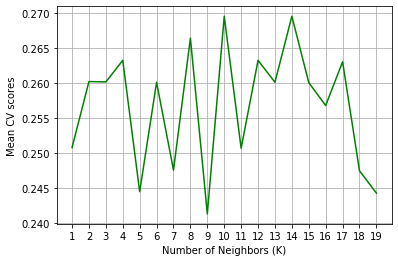

In [282]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

mean_scores=[]

for n in range(1,Ks):
    #Train Model and Predict  
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=n))])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    mean_scores.append(scores.mean())

#    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
#    yhat=neigh.predict(X_test)
#    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
#    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#mean_acc

plt.plot(range(1,Ks),mean_scores,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
#plt.legend(('Accuracy ', '+/- 3xstd'))
#plt.ylabel('Accuracy ')
plt.ylabel('Mean CV scores')
plt.xlabel('Number of Neighbors (K)')
plt.xticks(range(1,Ks))
plt.grid()
#plt.tight_layout()
plt.show()

In [285]:
print(mean_scores[9])
print(mean_scores[13])

0.2695436507936508
0.2695436507936508


Use 10 neighbors or 14 neighbors.

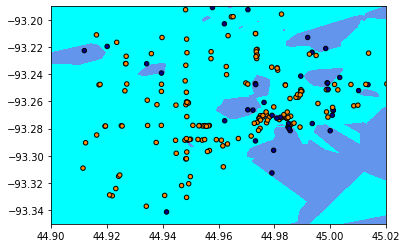

In [312]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

#n_neighbors = 
k=2
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
yhat = neigh.predict(X_test)

# import some data to play with
#iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
#X = iris.data[:, :2]
#y = iris.target

h = 0.0001  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

#for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    #clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    #clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = 44.9, 45.02
y_min, y_max = -93.35, -93.19
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
yhat = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
yhat = yhat.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i, weights = '%s')"
#              % (n_neighbors, weights))

plt.show()

In [293]:
[(XX['venue.location.lat'].max()-XX['venue.location.lat'].min())/100, (XX['venue.location.lng'].max()-XX['venue.location.lng'].min())/100]

[0.0035138193599135547, 0.005493405446240019]

## Choropleth map of brewery density using Geopandas

In [44]:
# Make Minneapolis neighborhoods
#mpls_geo = gpd.read_file('Minneapolis_Neighborhoods.geojson.json')
#mpls_geo = mpls_geo[['geometry', 'BDNAME']]
#mpls_geo['city']=pd.Series(['Minneapolis']*len(mpls_geo))

# Minneapolis communities are closer in size to the St. Paul neighborhoods.
# If we prefer to consider Minneapolis communities and St. Paul neighborhoods, comment the above code and
# run the following instead.

mpls_geo = gpd.read_file('Communities.geojson')
mpls_geo = mpls_geo[['geometry', 'CommName']]
mpls_geo['city']=pd.Series(['Minneapolis']*len(mpls_geo))
mpls_geo.rename(columns={'CommName':'BDNAME'}, inplace=True) # Rename so columns match

# Make St. Paul neighborhoods
stp_geo = gpd.read_file('stp_neighborhoods.geojson')
stp_geo = stp_geo[['geometry', 'name2']]
stp_geo.rename(columns={'name2':'BDNAME'}, inplace=True) # Rename so columns match
stp_geo['city']=pd.Series(['St. Paul']*len(stp_geo))

# Combine to twin cities neighborhoods
tc_geo=pd.concat([mpls_geo, stp_geo]).drop_duplicates().reset_index(drop=True)
print(tc_geo.shape)
tc_geo.head()

(28, 3)


geometry      BDNAME         city
0  MULTIPOLYGON (((-93.31949 45.05125, -93.31823 ...      Camden  Minneapolis
1  MULTIPOLYGON (((-93.22685 45.01322, -93.22685 ...   Northeast  Minneapolis
2  MULTIPOLYGON (((-93.31784 45.01326, -93.31744 ...  Near North  Minneapolis
3  MULTIPOLYGON (((-93.27211 44.99213, -93.27157 ...     Central  Minneapolis
4  MULTIPOLYGON (((-93.20761 45.00153, -93.20760 ...  University  Minneapolis

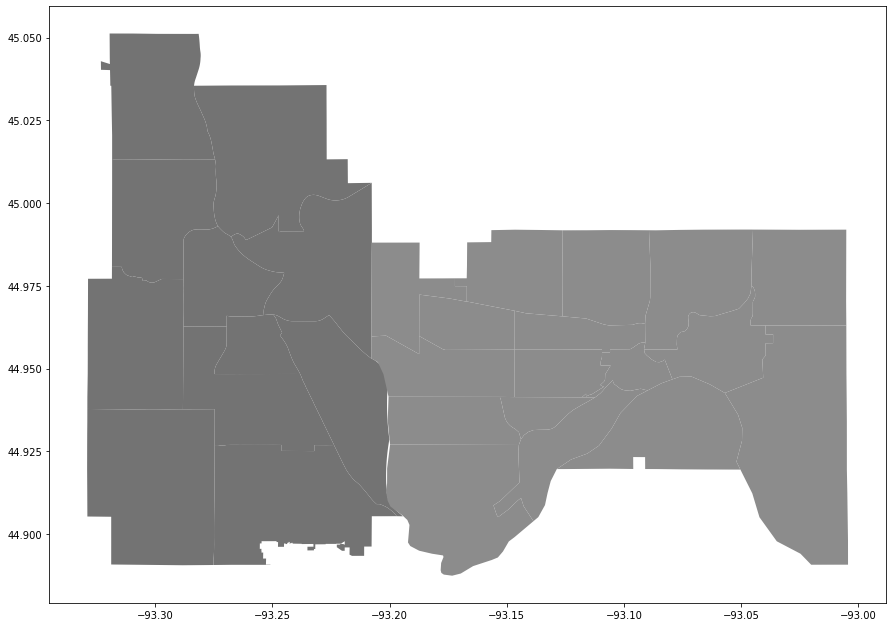

In [45]:
fig, ax = plt.subplots(figsize = (15,15))
#tc_geo.plot(ax=ax, facecolor='black')
mpls_geo.plot(ax=ax, facecolor='.45') # color between 0 and 1 is greyscale. 0 is darker. 1 is lighter.
stp_geo.plot(ax=ax, facecolor='.55')

#### Turn df_brew in geodataframe and count breweries in neighborhoods

In [54]:
# Turn df_brew into geodatafram
df_brew_geo = gpd.GeoDataFrame(df_brew, geometry=gpd.points_from_xy(df_brew['venue.location.lng'], df_brew['venue.location.lat']))
df_brew_geo.head()

brewery_count=[]
for j in range(0,len(tc_geo)):
    nbhd = tc_geo.loc[j,'BDNAME']  # nbhd is jth neighborhood name, string
    nbhd_geo = tc_geo[tc_geo['BDNAME'] == nbhd]  # nbhd_geo is jth row
    nbhd_geo.reset_index(drop=True, inplace=True)  # reset index of dataframe
    nbhd_mask = df_brew_geo['geometry'].within(nbhd_geo.loc[0,'geometry'])  # Boolean mask of breweries in nbhd.
    brewery_count.append(sum(nbhd_mask))  # create list of brewery counts per neighborhood.

# Add column to tc_geo    
tc_geo['Brewery Count'] = pd.Series(brewery_count) # add brewery count column

Text(0.5, 1, 'Choropleth map of breweries in Minneapolis communities and St. Paul neighborhoods')

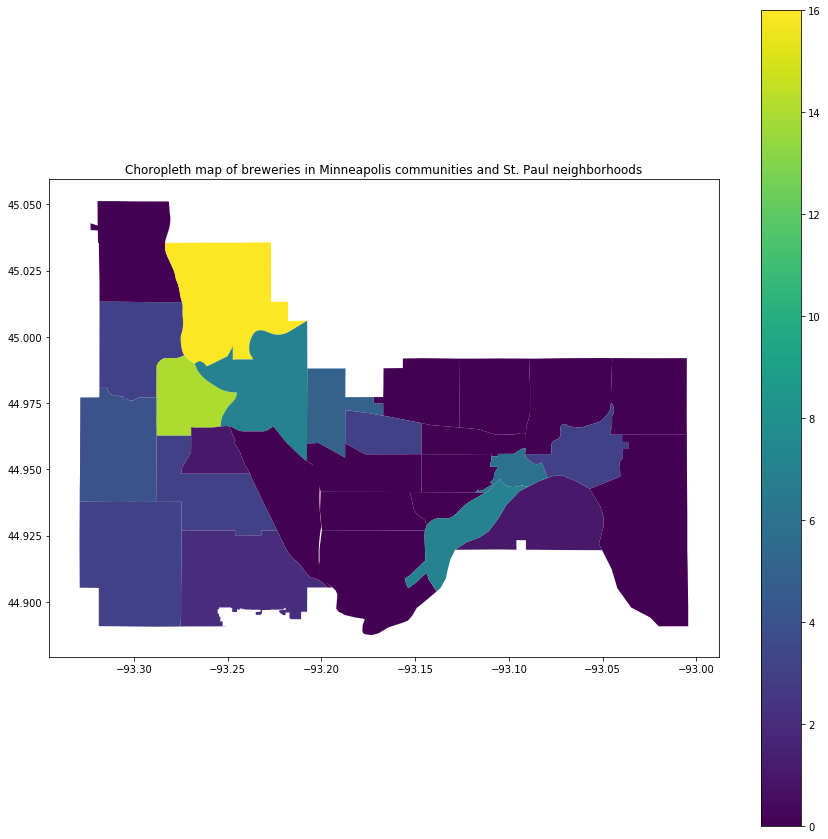

In [55]:
fig, ax = plt.subplots(figsize = (15,15))
#tc_geo.plot(ax=ax, facecolor='black')
#mpls_geo.plot(ax=ax, facecolor='.45') # color between 0 and 1 is greyscale. 0 is darker. 1 is lighter.
#stp_geo.plot(ax=ax, facecolor='.55')
tc_geo.plot(column='Brewery Count', ax=ax, legend=True)
plt.title('Choropleth map of breweries in Minneapolis communities and St. Paul neighborhoods')

## Put breweries into their neighborhoods/communities 

In [1]:
def get_nbhd(index):
    return nbhds.loc[index, 'Neighborhood']

brew_dict={}
# Identify brewery neighborhoods
for nbhd in range(0,len(nbhds)):
    nbhd_temp = mpls_geo[mpls_geo['BDNAME']==get_nbhd(nbhd)]
    nbhd_temp.reset_index(drop=True, inplace=True)
#    print(nbhd_temp)
    for index in range(0,len(df_brew)):
        nbhd_temp_mask = nbhd_temp.loc[0,'geometry'].contains(df_brew_geo['geometry'][index])
#        print(nbhd_temp_mask)
#        nbhd_temp_mask = df_brew_geo['geometry'][index].within(nbhd_temp.loc[0,'geometry'])
        if nbhd_temp_mask == True:           
            print('Brewery {} is in {}'.format(df_brew_geo['venue.name'][index], nbhd_temp.loc[0,'BDNAME'] ))
            brew_dict[df_brew_geo['venue.name'][index]]=get_nbhd(nbhd)

brew_dict        

NameError: name 'nbhds' is not defined

In [173]:
# Take our brew_dict and turn it into a DataFrame.
brew_dict=pd.DataFrame.from_dict(brew_dict, orient='index', columns=['Neighborhood'])
brew_dict.reset_index(inplace=True)
brew_dict.rename(columns={'index':'venue.name'}, inplace=True)
brew_dict.head()

50

In [191]:
df_brew = pd.merge(df_brew, brew_dict, on='venue.name')
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng  \
0          414 6th Ave N           44.984862          -93.278828   
1         1300 2nd St NE           45.001049          -93.266337   
2     520 Malcolm Ave SE           44.973226          -93.210072   
3       1368 Lasalle Ave           44.968908          -93.279479   
4          817 5th Ave S           44.972301          -93.266410   

                                         lonlat                    geometry  \
0  POINT (-93.27882817717484 44.98486196804922)  POINT (-93.27883 44.98486)   
1   POINT (-93.2663365843227 45.00104863763394)  POINT (-93.26634 45.00105)   
2  POINT (-93.21007190901628 44.97322598772595)  POINT (-93.21007 44.97323)   
3  POINT (-93.27947928511085 44.96890779142156)  POINT (-93.27948 44.96891)   
4  POINT (-93.26640996574511 44.97230088563604)  POINT (-93.26641 44.97230)   

                    Neighborhood_x                   Neighborhood_y  \
0                       North Loop                       North Loop   
1                         Sheridan                         Sheridan   
2  Prospect Park - East River Road  Prospect Park - East River Road   
3                      Loring Park                      Loring Park   
4                      Elliot Park                      Elliot Park   

                      Neighborhood  
0                       North Loop  
1                         Sheridan  
2  Prospect Park - East River Road  
3                      Loring Park  
4                      Elliot Park

In [174]:
df_brew.set_index('venue.name')
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng  \
0          414 6th Ave N           44.984862          -93.278828   
1         1300 2nd St NE           45.001049          -93.266337   
2     520 Malcolm Ave SE           44.973226          -93.210072   
3       1368 Lasalle Ave           44.968908          -93.279479   
4          817 5th Ave S           44.972301          -93.266410   

                                         lonlat                    geometry  
0  POINT (-93.27882817717484 44.98486196804922)  POINT (-93.27883 44.98486)  
1   POINT (-93.2663365843227 45.00104863763394)  POINT (-93.26634 45.00105)  
2  POINT (-93.21007190901628 44.97322598772595)  POINT (-93.21007 44.97323)  
3  POINT (-93.27947928511085 44.96890779142156)  POINT (-93.27948 44.96891)  
4  POINT (-93.26640996574511 44.97230088563604)  POINT (-93.26641 44.97230)

In [192]:
df_brew.drop(columns=['lonlat', 'Neighborhood_x', 'Neighborhood_y'], inplace=True)

In [193]:
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng  \
0          414 6th Ave N           44.984862          -93.278828   
1         1300 2nd St NE           45.001049          -93.266337   
2     520 Malcolm Ave SE           44.973226          -93.210072   
3       1368 Lasalle Ave           44.968908          -93.279479   
4          817 5th Ave S           44.972301          -93.266410   

                     geometry                     Neighborhood  
0  POINT (-93.27883 44.98486)                       North Loop  
1  POINT (-93.26634 45.00105)                         Sheridan  
2  POINT (-93.21007 44.97323)  Prospect Park - East River Road  
3  POINT (-93.27948 44.96891)                      Loring Park  
4  POINT (-93.26641 44.97230)                      Elliot Park

## Choropleth

In [195]:
df_mpls_brew=pd.DataFrame(df_brew['Neighborhood'].value_counts())

In [198]:
df_mpls_brew = df_mpls_brew.reset_index()

In [200]:
df_mpls_brew.rename(columns={'index':'Neighborhood','Neighborhood':'Brewery Count'}, inplace=True)
df_mpls_brew.head()

Neighborhood  Brewery Count
0             North Loop              6
1         Northeast Park              4
2          Downtown West              3
3  Mid - City Industrial              3
4        Cedar Riverside              2

In [230]:
# create a numpy array of length 6 and has linear spacing from the minium total
# breweries to the maximum total breweries
threshold_scale = np.linspace(0,
                              df_mpls_brew['Brewery Count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

mpls_map = folium.Map(location=[mpls_latitude, mpls_longitude], zoom_start=13, tiles='Stamen Terrain')

mpls_map.choropleth(
    geo_data=mpls_data,
    data=df_mpls_brew,
    columns=['Neighborhood','Brewery Count'],
    key_on='feature.properties.BDNAME',
    threshold_scale=threshold_scale,
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name= 'Minneapolis Breweries',
    reset=True
)
mpls_map